In [1]:
import numpy as np
import cv2
import h5py
from matplotlib import pyplot as plt
import src.models as models
import pickle

In [2]:
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)

## Load core

In [3]:
corename = 's33_c070'
mask_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/mask/{corename}.png'
mask = cv2.imread(mask_filepath) / 255.0

annot_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/annotation/{corename}.png'
annot = cv2.imread(annot_filepath)[:,:,::-1] / 255.0

core_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/spectral/{corename}.h5'
f = h5py.File(core_filepath)
datacube = f['spectra'][:] * mask[:,:,0:1]
f.close()

print(f"Loaded core with shape: {datacube.shape} and mask with shape: {mask.shape} and annotations with shape {annot.shape}")

Loaded core with shape: (256, 256, 965) and mask with shape: (256, 256, 3) and annotations with shape (256, 256, 3)


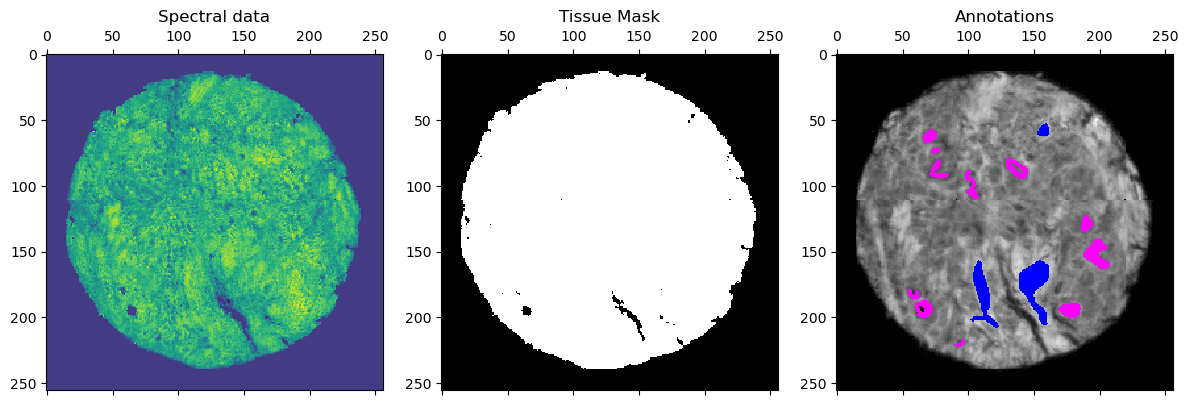

In [4]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].matshow(datacube[:,:,300]); ax[0].set_title("Spectral data")
ax[1].matshow(mask); ax[1].set_title("Tissue Mask")
ax[2].matshow(annot); ax[2].set_title("Annotations")
fig.tight_layout()

## Load model

In [5]:
model_use = 'randomforest'

if model_use == 'randomforest':
    with open(r'./model_weights/randomforest_fixed_weights_55.pt', 'rb') as f:
        model = pickle.load(f)
elif model_use == 'svm':
    with open(r'./model_weights/svm_fixed_weights_55.pt', 'rb') as f:
        model = pickle.load(f)

C:\Users\w37262do\AppData\Local\anaconda3\envs\survival\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\w37262do\AppData\Local\anaconda3\envs\survival\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\w37262do\AppData\Local\anaconda3\envs\survival\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpic

## Predict

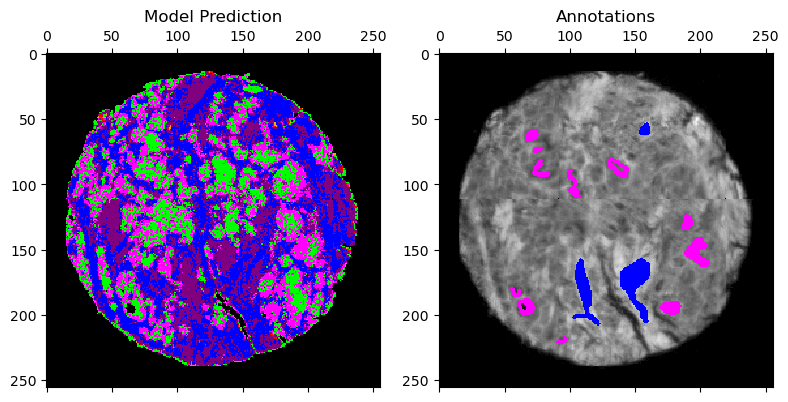

In [6]:
out = np.zeros((256,256))
for row_idx, row in enumerate(datacube):
    out[row_idx] = model.predict(row)
pred = annotation_class_colors[out.astype(int)] * mask / 255.0

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(pred); ax[0].set_title("Model Prediction")
ax[1].matshow(annot); ax[1].set_title("Annotations")
fig.tight_layout()

## Save output

In [7]:
cv2.imwrite(f'./pred_images/{model_use}_{corename}.png', np.rint(pred[..., ::-1] * 255.0))

True